### 1. Introduction
In the past few years, Austin, Texas has been widely recognized by many media as the best city to live in the United States (https://www.cnbc.com/2019/04/15/us-news-world-report-best-places-to-live-in-the-us-in-2019.html). With an ever increasing cluster of high-tech companies, this growing Austin metropolitan area is thus nicknamed silicon hills. The name is analogous to Silicon Valley, but refers to the hilly terrain on the west side of Austin. High tech industries in the area include enterprise software, semiconductors, corporate R&D, biotechnology, the video game industry, and a variety of startup companies.
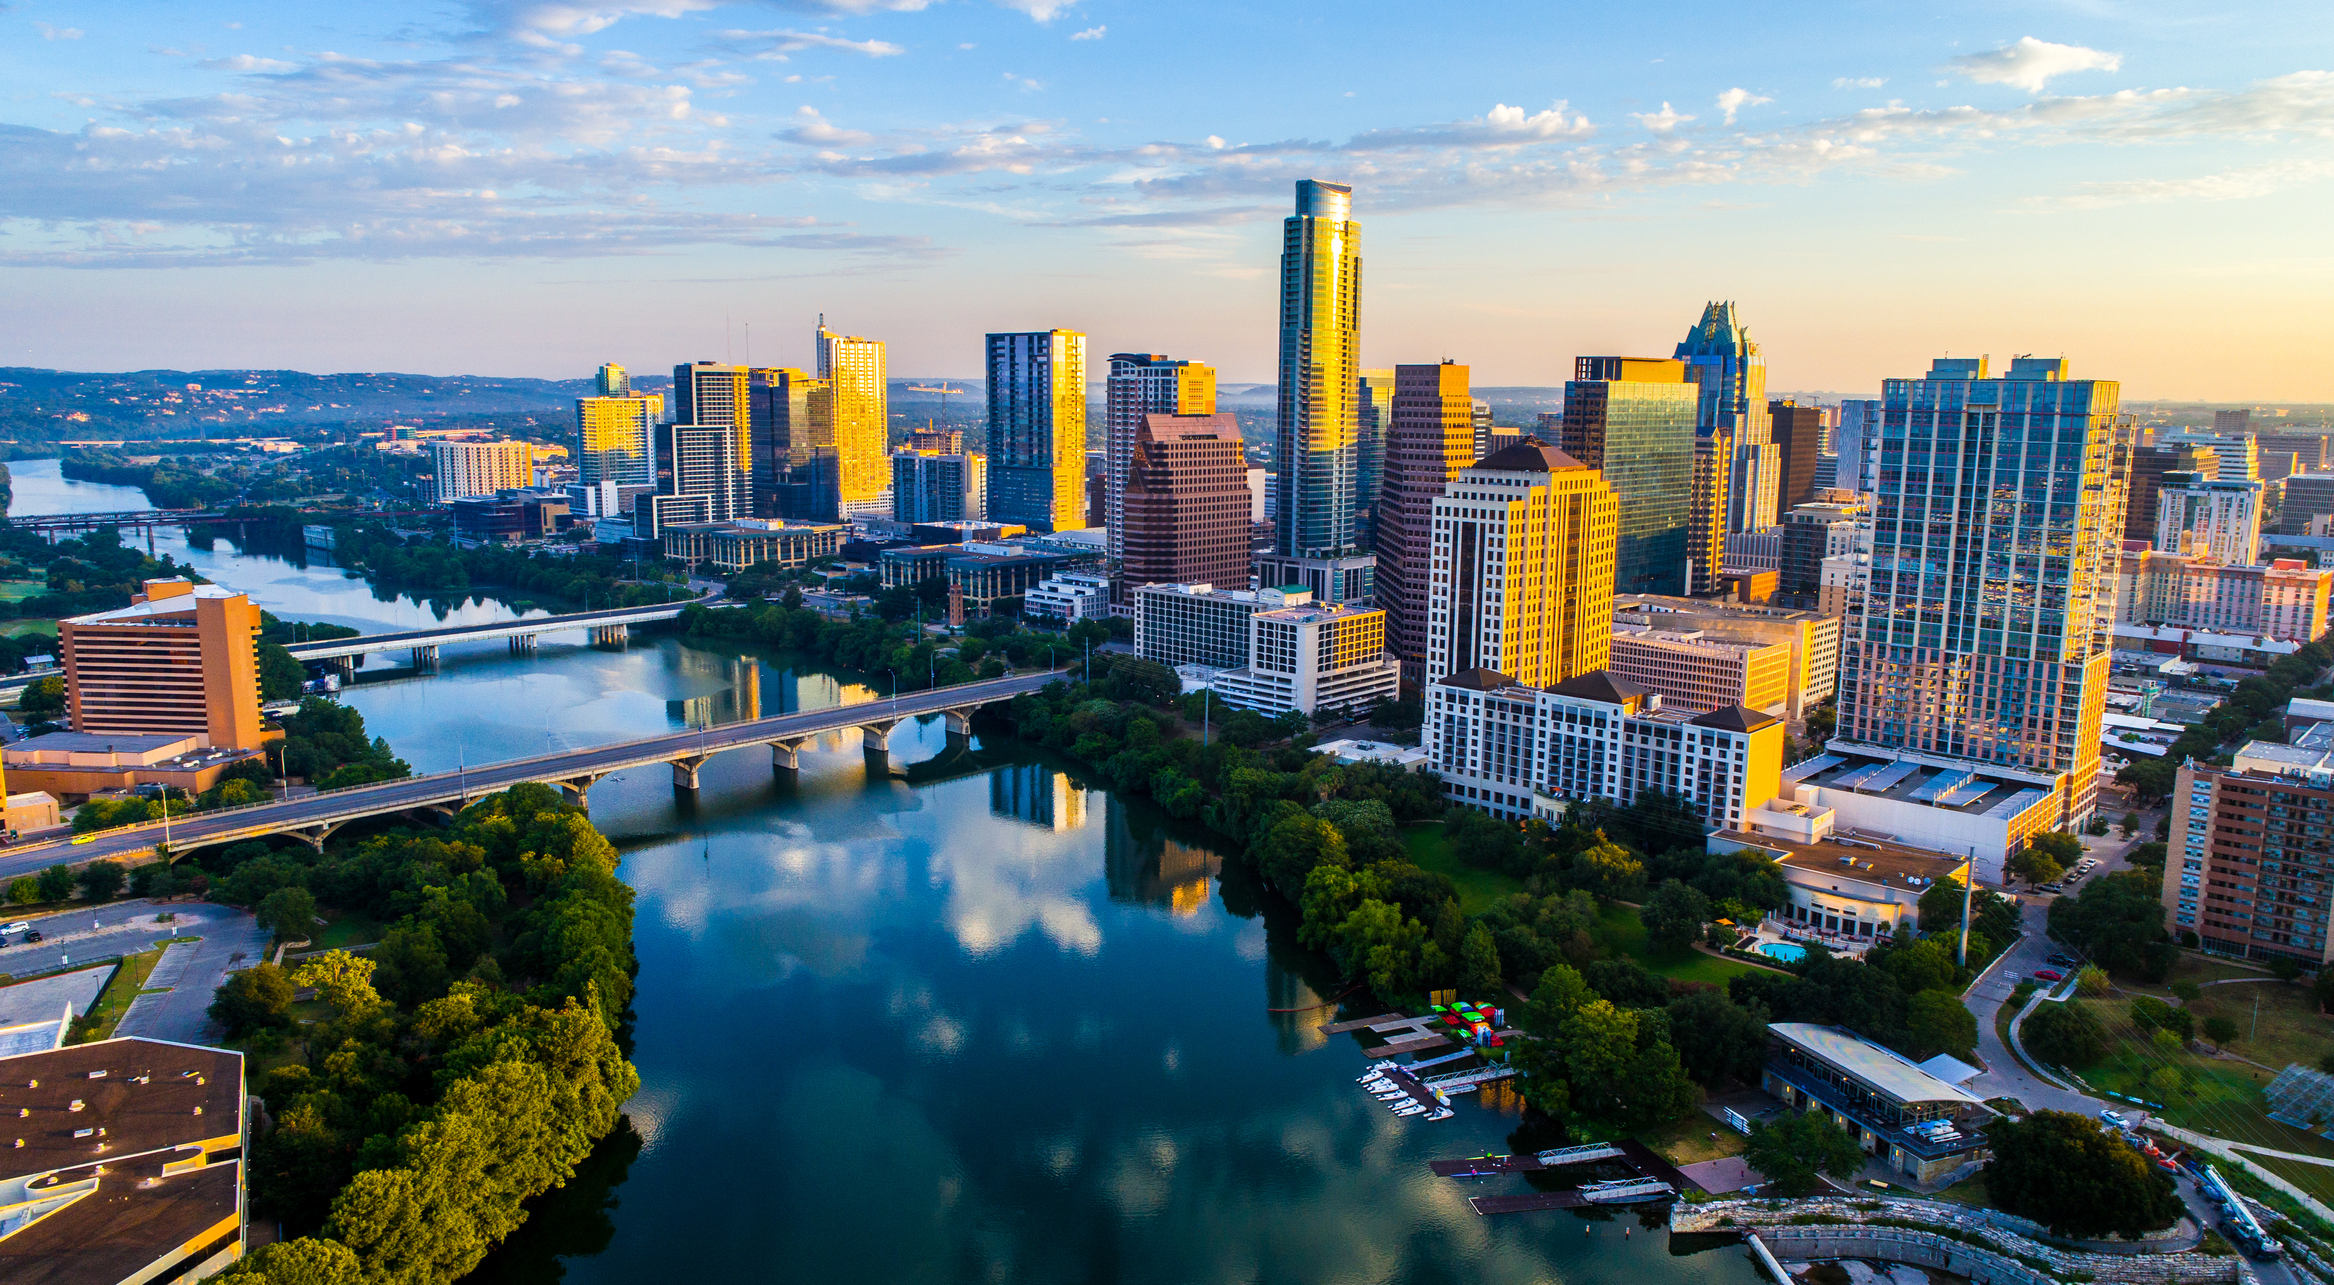

Seattle and San Francisco are the two existing gravity centers of the tech industry. Among the five largest tech companies in the United States, three (Apple, Alphabet, Facebook) headquartered in San Francisco area and two (Microsoft and Amazon) based their roots in Seattle area. Therefore, one would ask the question how different is the emerging Austin from the two existing tech centers on the west coast? How can Austin develop its city to better catch up with the two leading champions?
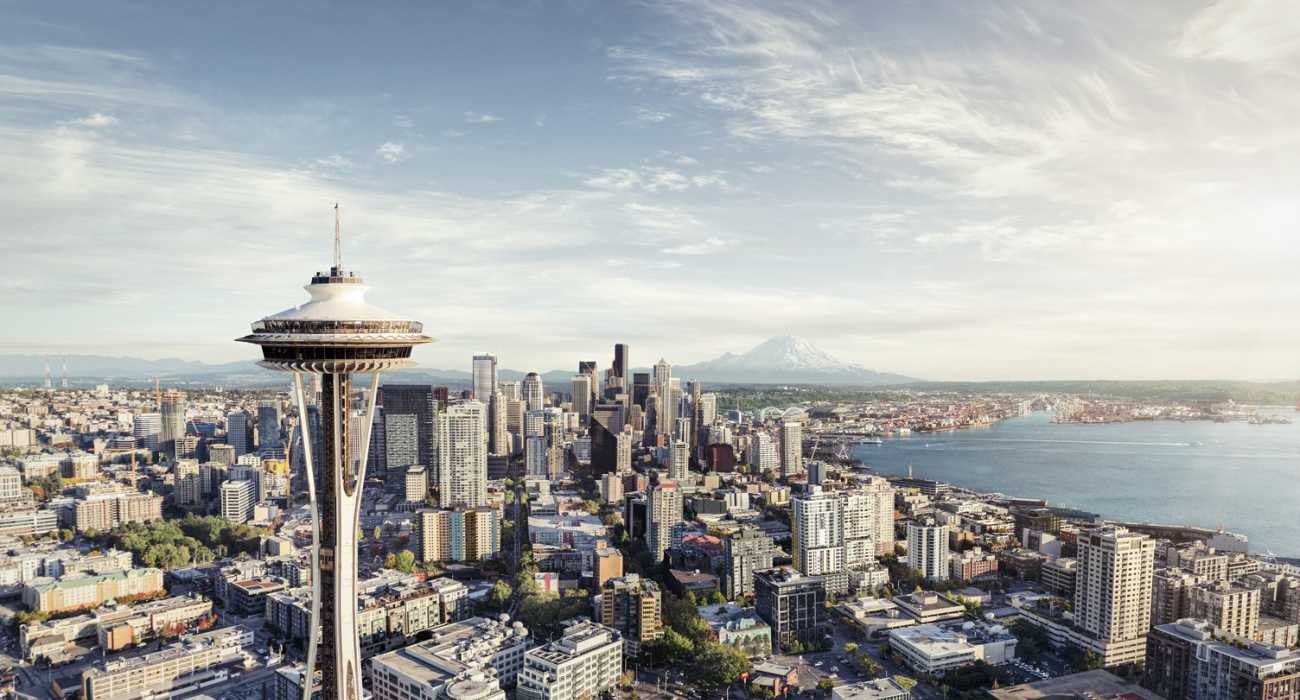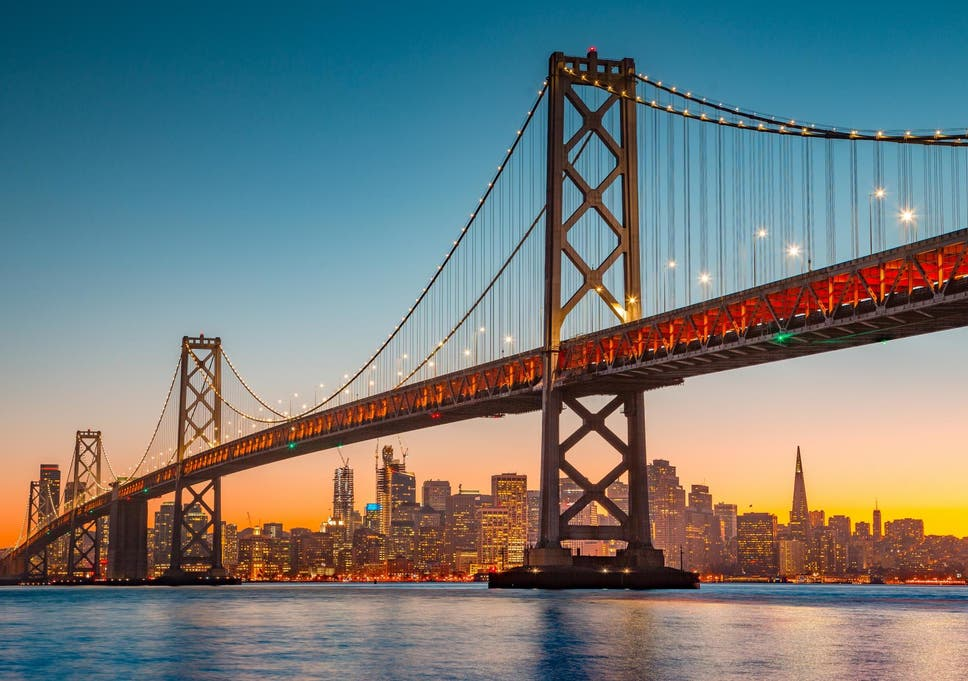

This project compares distribution of venues in Austin to that in Seattle and San Francisco. The comparison aims to explore how Austin can develop itself with respect to venues to catch up with Seattle and San Francisco.

### 2. Data Requirement 
This prject contians the following data:

1) Zip code of the three three cities with associted latitude and longitude<br> 
The Zip code will be used as surrogate of neighborhood of each city. The data is available from: https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/

2) Venues in each zip code area in the three cities:<br>
Venues will be obtained from Foursquare APIs. By using this API, we will get all the venues in each zip code.

#### 2.1 Location Data Preparation
We first import all the needed modules 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt


# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

In this study, we use zip codes as the surrogate for neighborhoods. We find zipcodes of all the cities in the United States along with latitude and longitude from the following website.

In [2]:
#https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/

df = pd.read_csv('us-zip-code-latitude-and-longitude.csv')
df = df.drop(['Timezone','Daylight savings time flag'], axis=1)

In the United States, there are many cities in different states with the same name. For example, there is Austin in Texas, Minnesota, Arkansas, and Indiana. Therefore, the dataframe is filtered out by both city name and state. Finally, a dataframe containing all the zip codes in Austin, Seattle, and San Francisco is obtained.

In [3]:
city=['Austin','Seattle','San Francisco']
df_1=df.loc[(df['City']=='Austin')&(df['State'] == 'TX')]
df_2=df.loc[(df['City']=='Seattle')&(df['State'] == 'WA')]
df_3=df.loc[(df['City']=='San Francisco')&(df['State'] == 'CA')]
frame=[df_1,df_2,df_3]
df_three=pd.concat(frame)
df_three.reset_index(inplace=True)
df_three.rename(columns={'Zip':'Zip Code'}, inplace=True)
df_three = df_three.drop('index', axis=1)
df_three.head()

Zip Code    City State   Latitude  Longitude
0     78701  Austin    TX  30.271270 -97.741030
1     78705  Austin    TX  30.292424 -97.738560
2     78727  Austin    TX  30.425652 -97.714190
3     78762  Austin    TX  30.326374 -97.771258
4     78763  Austin    TX  30.335398 -97.559807

#### 2.2 Exploratory Data Preparation
Foursquare Credentials and Version were defined. The Foursquare API will get the top 100 venues in each zip code area within a radius of 5000 meters.

In [4]:
CLIENT_ID = 'VZV2XVTGSGOPBFSNTDGZFKNAAOKSSDNORH5S5G4QB244PAVQ' # your Foursquare ID
CLIENT_SECRET = 'SXK2KXI0BBIXVH0ZSXEAT1X0H5AT5PPSFQPXAZXDKC0ZNJKO' # your Foursquare Secret
VERSION = '20180604'

limit=100
radius=5000

Create a function to explore all the zip codes in Austin, Seattle, and San Francisco.

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip Code', 
                  'Zip Code Latitude', 
                  'Zip Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [6]:
# run function getNearbyVenues on each zip code
three_venues = getNearbyVenues(names=df_three['Zip Code'],
                                   latitudes=df_three['Latitude'],
                                   longitudes=df_three['Longitude']
                                  )
three_venues.head()

Zip Code  Zip Code Latitude  Zip Code Longitude                    Venue  \
0     78701           30.27127           -97.74103           Chi'lantro BBQ   
1     78701           30.27127           -97.74103             Caffé Medici   
2     78701           30.27127           -97.74103  Capitol Visitors Center   
3     78701           30.27127           -97.74103        Paramount Theatre   
4     78701           30.27127           -97.74103             The Townsend   

   Venue Latitude  Venue Longitude    Venue Category  
0       30.270600       -97.741928        Food Truck  
1       30.270119       -97.742154       Coffee Shop  
2       30.272625       -97.739300  Capitol Building  
3       30.269457       -97.742077     Movie Theater  
4       30.269611       -97.742448            Lounge

### 3. Analysis and Discussion
To explore the distribution of venues in each zip code, we analyze each zip code with pandas one hot encoding for the venue categories.

In [7]:
# one hot encoding
three_onehot = pd.get_dummies(three_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
three_onehot['Zip Code'] = three_venues['Zip Code'] 

# move neighborhood column to the first column
fixed_columns = [three_onehot.columns[-1]] + list(three_onehot.columns[:-1])
three_onehot = three_onehot[fixed_columns]

three_onehot.head()

Zip Code  ATM  Acai House  Accessories Store  Adult Boutique  \
0     78701    0           0                  0               0   
1     78701    0           0                  0               0   
2     78701    0           0                  0               0   
3     78701    0           0                  0               0   
4     78701    0           0                  0               0   

   African Restaurant  Alternative Healer  American Restaurant  \
0                   0                   0                    0   
1                   0                   0                    0   
2                   0                   0                    0   
3                   0                   0                    0   
4                   0                   0                    0   

   Animal Shelter  Antique Shop  Arcade  Art Gallery  Art Museum  \
0               0             0       0            0           0   
1               0             0       0            0           0   
2               0             0       0            0           0   
3               0             0       0            0           0   
4               0             0       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Assisted Living  Athletics & Sports  \
0                    0                 0                0                   0   
1                    0                 0                0                   0   
2                    0                 0                0                   0   
3                    0                 0                0                   0   
4                    0                 0                0                   0   

   Auto Garage  Automotive Shop  BBQ Joint  Bagel Shop  Bakery  Bank  Bar  \
0            0                0          0           0       0     0    0   
1            0                0          0           0       0     0    0   
2            0                0          0           0       0     0    0   
3            0                0          0           0       0     0    0   
4            0                0          0           0       0     0    0   

   Baseball Field  Basketball Court  Beach  Bed & Breakfast  Beer Bar  \
0               0                 0      0                0         0   
1               0                 0      0                0         0   
2               0                 0      0                0         0   
3               0                 0      0                0         0   
4               0                 0      0                0         0   

   Beer Garden  Beer Store  Bike Shop  Bistro  Boat or Ferry  Bookstore  \
0            0           0          0       0              0          0   
1            0           0          0       0              0          0   
2            0           0          0       0              0          0   
3            0           0          0       0              0          0   
4            0           0          0       0              0          0   

   Botanical Garden  Boutique  Bowling Alley  Boxing Gym  Breakfast Spot  \
0                 0         0              0           0               0   
1                 0         0              0           0               0   
2                 0         0              0           0               0   
3                 0         0              0           0               0   
4                 0         0              0           0               0   

   Brewery  Bridal Shop  Bubble Tea Shop  Building  Burger Joint  \
0        0            0                0         0             0   
1        0            0                0         0             0   
2        0            0                0         0             0   
3        0            0                0         0             0   
4        0            0                0         0             0   

   Burmese Restaurant  Burrito Place  Bus Line  Bus Station  Bus Stop  \
0              

In [8]:
three_grouped = three_onehot.groupby('Zip Code').mean().reset_index()

A dataframe was then created for each zip code along with the top 20 most common venues categories in each zip code.

In [9]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [10]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcodes_venues_sorted = pd.DataFrame(columns=columns)
zipcodes_venues_sorted['Zip Code'] = three_grouped['Zip Code']

for ind in np.arange(three_grouped.shape[0]):
    zipcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(three_grouped.iloc[ind, :], num_top_venues)

zipcodes_venues_sorted.head()

Zip Code 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     73301                  Lake           Yoga Studio            Eye Doctor   
1     73344                  Lake           Yoga Studio            Eye Doctor   
2     78701          Cocktail Bar                 Hotel        Sandwich Place   
3     78702    Mexican Restaurant           Coffee Shop     Convenience Store   
4     78703          Home Service                  Park                 Trail   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                  Farm        Farmers Market  Fast Food Restaurant   
1                  Farm        Farmers Market  Fast Food Restaurant   
2         Movie Theater          Burger Joint            Food Truck   
3                   Pub  Fast Food Restaurant          Cocktail Bar   
4     Mobile Phone Shop         Fishing Store                  Farm   

    7th Most Common Venue     8th Most Common Venue 9th Most Common Venue  \
0                   Field       Filipino Restaurant     Fish & Chips Shop   
1                   Field       Filipino Restaurant     Fish & Chips Shop   
2             Coffee Shop  Mediterranean Restaurant                Lounge   
3  Thrift / Vintage Store                   Butcher        Breakfast Spot   
4          Farmers Market      Fast Food Restaurant                 Field   

  10th Most Common Venue 11th Most Common Venue 12th Most Common Venue  \
0            Fish Market          Fishing Store            Flea Market   
1            Fish Market          Fishing Store            Flea Market   
2       Capitol Building            Pizza Place             Whisky Bar   
3              Gift Shop         Sandwich Place                    Bar   
4    Filipino Restaurant      Fish & Chips Shop            Fish Market   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
0            Flower Shop                   Food      Food & Drink Shop   
1            Flower Shop                   Food      Food & Drink Shop   
2              Speakeasy          Grocery Store                   Café   
3                   Bank     English Restaurant             Food Truck   
4            Yoga Studio             Eye Doctor            Flea Market   

    16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
0               Food Court             Food Stand             Food Truck   
1               Food Court             Food Stand             Food Truck   
2  New American Restaurant                  Field              Gift Shop   
3                Wine Shop     Italian Restaurant         Ice Cream Shop   
4              Flower Shop                   Food      Food & Drink Shop   

  19th Most Common Venue 20th Most Common Venue  
0       Football Stadium               Fountain  
1       Football Stadium               Fountain  
2                   Park            Music Venue  
3      Electronics Store    Filipino Restaurant  
4             Food Court             Food Stand

#### 3.1 Clustering zip codes

Cluster zip codes based on distribution of venues categories. In this study, the zip codes will be clustered into 5 clusters. 

In [11]:
# set number of clusters
kclusters = 5

three_grouped_clustering = three_grouped.drop('Zip Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(three_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 0, 0, 0, 0, 0, 2, 2, 0])

In [12]:
# add clustering labels
zipcodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [13]:
three_merged = df_three

# merge three_grouped with df_three to add latitude/longitude for each zip code
three_merged = three_merged.join(zipcodes_venues_sorted.set_index('Zip Code'), on='Zip Code')

three_merged.head() # check the last columns!

Zip Code    City State   Latitude  Longitude  Cluster Labels  \
0     78701  Austin    TX  30.271270 -97.741030             0.0   
1     78705  Austin    TX  30.292424 -97.738560             0.0   
2     78727  Austin    TX  30.425652 -97.714190             0.0   
3     78762  Austin    TX  30.326374 -97.771258             2.0   
4     78763  Austin    TX  30.335398 -97.559807             0.0   

      1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0              Cocktail Bar                 Hotel        Sandwich Place   
1              Burger Joint            Food Truck              Boutique   
2  Mediterranean Restaurant          Intersection        Cosmetics Shop   
3                      Lake           Yoga Studio            Eye Doctor   
4            Discount Store                   Bar           Video Store   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0         Movie Theater          Burger Joint            Food Truck   
1     Convenience Store           Coffee Shop            Taco Place   
2         Fishing Store      Sushi Restaurant       Thai Restaurant   
3                  Farm        Farmers Market  Fast Food Restaurant   
4           Flea Market                  Farm        Farmers Market   

  7th Most Common Venue     8th Most Common Venue 9th Most Common Venue  \
0           Coffee Shop  Mediterranean Restaurant                Lounge   
1                   Pub            Sandwich Place                   Bar   
2                   Gym                      Bank                Bakery   
3                 Field       Filipino Restaurant     Fish & Chips Shop   
4  Fast Food Restaurant                     Field   Filipino Restaurant   

  10th Most Common Venue 11th Most Common Venue 12th Most Common Venue  \
0       Capitol Building            Pizza Place             Whisky Bar   
1         Shipping Store   Fast Food Restaurant              Rock Club   
2            Coffee Shop      Convenience Store        Motorcycle Shop   
3            Fish Market          Fishing Store            Flea Market   
4      Fish & Chips Shop            Fish Market          Fishing Store   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
0              Speakeasy          Grocery Store                   Café   
1         Clothing Store             Sports Bar     Mexican Restaurant   
2            Video Store            Dry Cleaner               Pharmacy   
3            Flower Shop                   Food      Food & Drink Shop   
4            Yoga Studio            Flower Shop            Fabric Shop   

    16th Most Common Venue     17th Most Common Venue 18th Most Common Venue  \
0  New American Restaurant                      Field              Gift Shop   
1              Beer Garden  Middle Eastern Restaurant      Food & Drink Shop   
2              Flea Market        Filipino Restaurant      Fish & Chips Shop   
3               Food Court                 Food Stand             Food Truck   
4        Food & Drink Shop                 Food Court             Food Stand   

   19th Most Common Venue 20th Most Common Venue  
0                    Park            Music Venue  
1  Thrift / Vintage Store            Bus Station  
2         Doctor's Office            Fish Market  
3        Football Stadium               Fountain  
4              Food Truck       Football Stadium

In [14]:
# drop any NaN value
three_merged.dropna(how='any',inplace=True)
three_merged.reset_index(inplace=True)
three_merged = three_merged.drop('index', axis=1)

In [15]:
three_merged['Cluster Labels'].value_counts()

0.0    102
1.0     44
2.0     29
3.0     23
4.0      1
Name: Cluster Labels, dtype: int64

#### 3.2 Analyze clusters
**Among cities.** The results indicates that . The distribution of clusters in each city is then analzyed.

In [16]:
# change type of Cluser Labels to int
three_merged['Cluster Labels']=three_merged['Cluster Labels'].astype('int64')

In [17]:
df_AUS=three_merged.loc[(three_merged['City']=='Austin')]
df_SEA=three_merged.loc[(three_merged['City']=='Seattle')]
df_SFO=three_merged.loc[(three_merged['City']=='San Francisco')]
df_AUS['Cluster Labels'].value_counts()

0    40
2    29
4     1
1     1
Name: Cluster Labels, dtype: int64

In [18]:
df_SEA['Cluster Labels'].value_counts()

0    34
3    23
Name: Cluster Labels, dtype: int64

In [19]:
df_SFO['Cluster Labels'].value_counts()

1    43
0    28
Name: Cluster Labels, dtype: int64

A bar plot was plotted to show the distribution of clusters in each city.

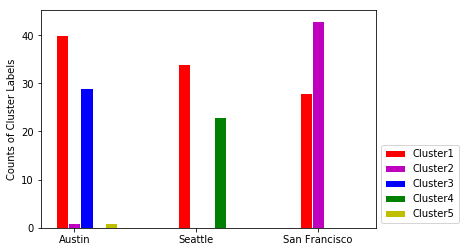

In [114]:
# set width of bar
barWidth = 0.1
 
# set height of bar based on value_counts of clusters
Cluster1 = [40,34,28]
Cluster2 = [1,0,43]
Cluster3 = [29,0,0]
Cluster4 = [0,23,0]
Cluster5 = [1,0,0]
 
# Set position of bar on X axis
r1 = np.arange(len(Cluster1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.bar(r1, Cluster1, color='r', width=barWidth, edgecolor='white', label='Cluster1')
plt.bar(r2, Cluster2, color='m', width=barWidth, edgecolor='white', label='Cluster2')
plt.bar(r3, Cluster3, color='b', width=barWidth, edgecolor='white', label='Cluster3')
plt.bar(r4, Cluster4, color='g', width=barWidth, edgecolor='white', label='Cluster4')
plt.bar(r5, Cluster5, color='y', width=barWidth, edgecolor='white', label='Cluster5')

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(Cluster1))], ['Austin', 'Seattle', 'San Francisco'])
plt.ylabel('Counts of Cluster Labels')

# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.show()

The bar plot shows that Cluster 1 is most common in both Austin and Seattle, while Cluster 2 is most common in San Francisco. All three cities have lots of zip codes fall under Cluster 1, but other than Cluster 1, venue clusters of the remaining zip codes differ among cities. In Austin, the other major cluster is Cluster 3 while Cluster 2 and 5 are very minimal. In Seattle, the other major cluster is Cluster 4, while no Cluster 2, 3 and 5 are detected in Seattle. In San Francisco, the other major cluster is Cluster 2, while no Cluster 3, 4 and 5 are detected. Therefore, these three cities are very different from each other with respect to clusters except that cluster 1 is a major cluster in all three cities.

**Composition of Clusters.** To visualize the detailed composition of each cluster, word cloud is used to help the major venue categories in each cluster.

In [20]:
# Cluster 1
Cluster1=three_merged.loc[three_merged['Cluster Labels'] == 0, three_merged.columns[[0,1] + list(range(5, three_merged.shape[1]))]]

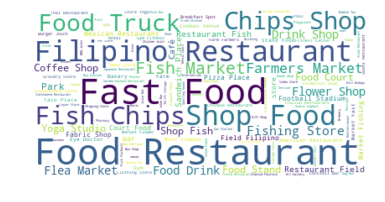

In [21]:
# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

# pass only venues to the word cluster, so drop unrelevant columns
text1=Cluster1.drop(['Zip Code','City','Cluster Labels'], axis=1)

# instantiate a word cloud object
Cluster1_wc = WordCloud(background_color='white').generate(str(text1))

# display the word cloud
plt.imshow(Cluster1_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

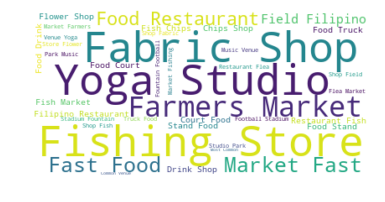

In [22]:
# Cluster 2
Cluster2=three_merged.loc[three_merged['Cluster Labels'] == 1, three_merged.columns[[0,1] + list(range(5, three_merged.shape[1]))]]

# pass only venues to the word cluster, so drop unrelevant columns
text2=Cluster2.drop(['Zip Code','City','Cluster Labels'], axis=1)

# instantiate a word cloud object
Cluster2_wc = WordCloud(background_color='white').generate(str(text2))

# display the word cloud
plt.imshow(Cluster2_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

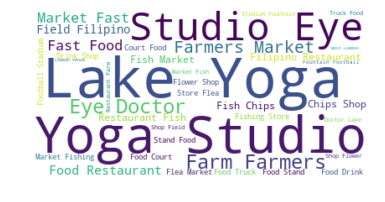

In [23]:
# Cluster 3
Cluster3=three_merged.loc[three_merged['Cluster Labels'] == 2, three_merged.columns[[0,1] + list(range(5, three_merged.shape[1]))]]

# pass only venues to the word cluster, so drop unrelevant columns
text3=Cluster3.drop(['Zip Code','City','Cluster Labels'], axis=1)

# instantiate a word cloud object
Cluster3_wc = WordCloud(background_color='white').generate(str(text3))

# display the word cloud
plt.imshow(Cluster3_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

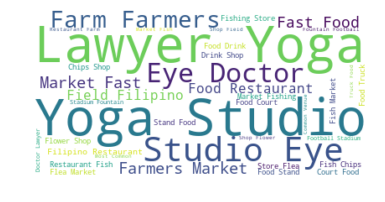

In [24]:
# Cluster 4
Cluster4=three_merged.loc[three_merged['Cluster Labels'] == 3, three_merged.columns[[0,1] + list(range(5, three_merged.shape[1]))]]

# pass only venues to the word cluster, so drop unrelevant columns
text4=Cluster4.drop(['Zip Code','City','Cluster Labels'], axis=1)

# instantiate a word cloud object
Cluster4_wc = WordCloud(background_color='white').generate(str(text4))

# display the word cloud
plt.imshow(Cluster4_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### 3.3 Visualize the clusters
Finally, we visualize the clusters using folium map.

In [26]:
# set latitude and longitude of Austin
latitude_austin = 30.2672
longitude_austin = -97.7431

# change latitude and longitude for Seattle (47.6062,-122.3321) or San Francisco (37.7749, -122.4194) and rerun the code to obtain maps of those two cities.

# create map
map_clusters = folium.Map(location=[latitude_austin, longitude_austin], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(three_merged['Latitude'], three_merged['Longitude'], three_merged['Zip Code'], three_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 4. Conclusion
In this study, the distribution of venue categories in Austin is compared to Seattle and San Francisco. Findings and recommendations are summarized below:
1. kmeans and word cloud are power tool to cluster and visualize venue composition of each zip code.
2. Austin is more similar to Seattle than to San Francisco.
3. All three cities have many zip codes whose primary venues are resturants.
4. San Francisco stands out in term of farmers market and fabric shops probably thanks to its more liberal living culture.
5. Austin can improve its attration to tech companies by develop more farmers market like San Francisco and develop more lawyers office like Seattle.